Figure 4  

Normalized distance diff between reported and true locations

In [1]:
# Imports
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse, Rectangle

# data handling
import pandas as pd
import numpy as np
import scipy

# data analysis
from scipy.stats import wilcoxon


In [2]:
dataDir = os.getcwd()
plotDir = '../plots'
# print(plotDir)
allDataDir = os.path.join(dataDir, 'mat', 'allData.mat')

# Load the .mat file
mat_data = scipy.io.loadmat(allDataDir)

# Access the 'allData' structure
all_data = mat_data['allData']

inBS - Mean: 0.875, Standard Deviation: 0.18298126367784998
Illusory distances - Test Statistic: 2296.0, p-value: 0.008083820499860297
Third distances - Test Statistic: 2973.0, p-value: 4.063800283591906e-08


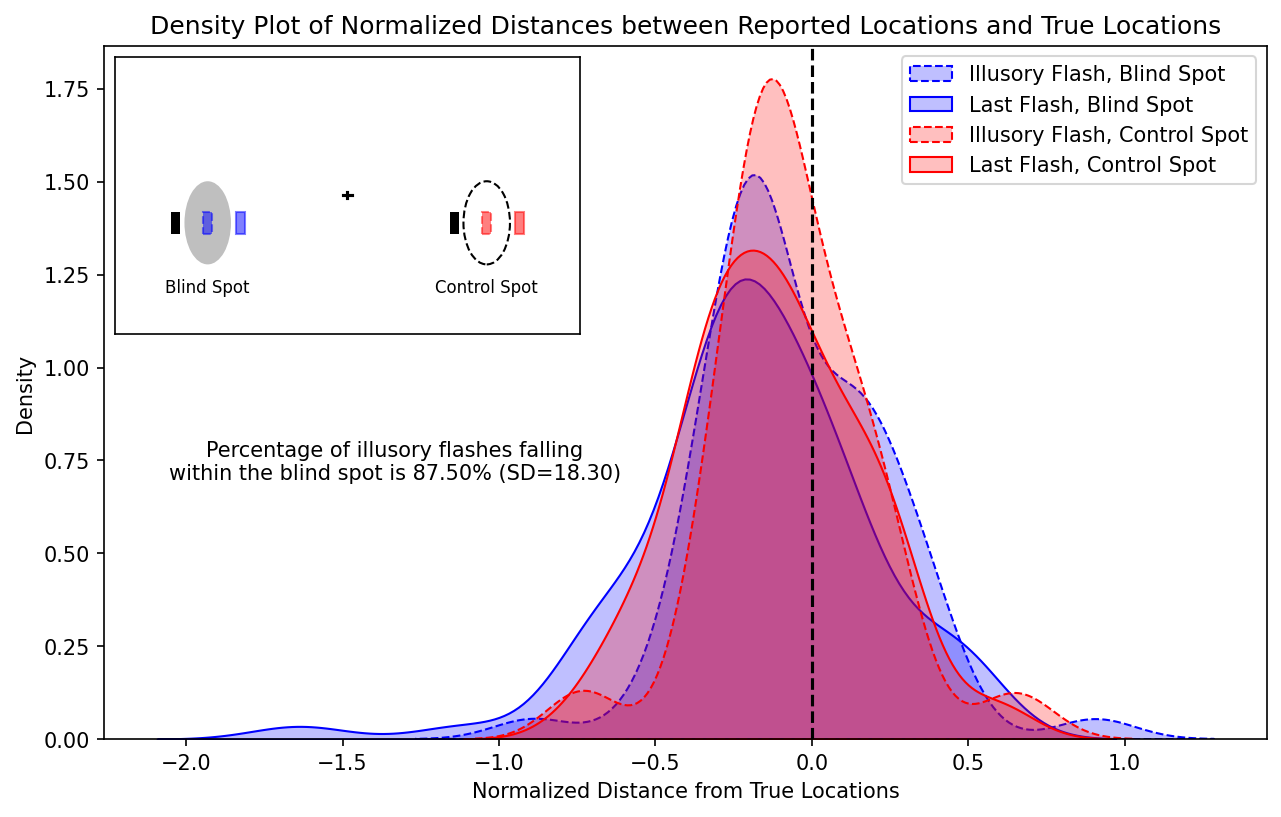

In [3]:
# Function to extract illusory and third distances
def extract_distances(f_extra_entry):
    illusory_dist = [entry[3][0][0] for entry in f_extra_entry]  # 4th column for illusory distances
    third_dist = [entry[4][0][0] for entry in f_extra_entry]     # 5th column for third distances
    return illusory_dist, third_dist

# List of subject IDs to include
subject_ids_to_include = ['SV009', 'SV012', 'SV026', 'SV027', 'SV028', 'SV029', 'SV030', 'SV031', 'SV032', 'SV033']

# Extract subject IDs and filter for the ones in subject_ids_to_include
subject_ids = np.array([sid[0] for sid in all_data['SID'][0]])  # Extract simple array of subject IDs
subject_indices = [i for i, sid in enumerate(subject_ids) if sid in subject_ids_to_include]

# Extract the corresponding F_extra data for these subjects
f_extra_subjects = all_data['F_extra'][0, subject_indices]
inBS = np.concatenate(all_data['inBS'][0, subject_indices])
# print(inBS)
# Calculate mean and standard deviation for inBS
inBS_mean = np.nanmean(inBS)
inBS_std = np.nanstd(inBS)
print(f"inBS - Mean: {inBS_mean}, Standard Deviation: {inBS_std}")

# Initialize lists to store distances
illusory_distances = []
third_distances = []

# Loop through each subject's F_extra data and extract distances
for subject_entry in f_extra_subjects:
    illusory, third = extract_distances(subject_entry)
    illusory_distances.extend(illusory)
    third_distances.extend(third)

# Remove NaN values from the distances
illusory_distances = [dist for dist in illusory_distances if not np.isnan(dist)]
third_distances = [dist for dist in third_distances if not np.isnan(dist)]
# inBS = [entry for entry in inBS if not np.isnan(entry)]
# print(inBS)

# Perform Wilcoxon signed-rank test comparing distances to zero
illusory_test_stat, illusory_p_value = wilcoxon(illusory_distances, zero_method='wilcox', correction=False)
third_test_stat, third_p_value = wilcoxon(third_distances, zero_method='wilcox', correction=False)

# Output the test results
print(f"Illusory distances - Test Statistic: {illusory_test_stat}, p-value: {illusory_p_value}")
print(f"Third distances - Test Statistic: {third_test_stat}, p-value: {third_p_value}")

# Assuming the earlier process of extracting data was successful, we use the same indices to separate the data:
blind_spot_indices = [0, 1, 2, 3, 8, 9, 10, 11]  # Python zero-based index
control_spot_indices = [i for i in range(len(f_extra_subjects[0])) if i not in blind_spot_indices]

# Function to extract distances based on indices
def extract_distances_by_spot(f_extra_entry, indices):
    illusory_dist = [entry[3][0][0] for idx, entry in enumerate(f_extra_entry) if idx in indices]
    third_dist = [entry[4][0][0] for idx, entry in enumerate(f_extra_entry) if idx in indices]
    return illusory_dist, third_dist

# Initialize lists to hold distances for both blind and control spots
illusory_blind_spot = []
third_blind_spot = []
illusory_control_spot = []
third_control_spot = []

# Loop through each subject's F_extra data to extract distances
for subject_entry in f_extra_subjects:
    illusory_blind, third_blind = extract_distances_by_spot(subject_entry, blind_spot_indices)
    illusory_control, third_control = extract_distances_by_spot(subject_entry, control_spot_indices)
    illusory_blind_spot.extend(illusory_blind)
    third_blind_spot.extend(third_blind)
    illusory_control_spot.extend(illusory_control)
    third_control_spot.extend(third_control)

# Function to clean and filter numeric data
def clean_data(data):
    return np.array([dist for dist in data if isinstance(dist, (int, float)) and np.isfinite(dist)])

# Clean the distances for plotting
illusory_blind_spot = clean_data(illusory_blind_spot)
third_blind_spot = clean_data(third_blind_spot)
illusory_control_spot = clean_data(illusory_control_spot)
third_control_spot = clean_data(third_control_spot)

# Create the density plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Plot density for blind spot
sns.kdeplot(illusory_blind_spot, fill=True, color="blue", label="Illusory Flash, Blind Spot", linestyle="--", ax=ax)
sns.kdeplot(third_blind_spot, fill=True, color="blue", label="Last Flash, Blind Spot", ax=ax)

# Plot density for control spot
sns.kdeplot(illusory_control_spot, fill=True, color="red", label="Illusory Flash, Control Spot", linestyle="--", ax=ax)
sns.kdeplot(third_control_spot, fill=True, color="red", label="Last Flash, Control Spot", ax=ax)

# Plot a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='--')

# Add labels and title
ax.set_title('Density Plot of Normalized Distances between Reported Locations and True Locations')
ax.set_xlabel('Normalized Distance from True Locations')
ax.set_ylabel('Density')
ax.legend()

# Add a sentence to the plot
percentage_text = f"Percentage of illusory flashes falling\nwithin the blind spot is {inBS_mean*100:.2f}% (SD={inBS_std*100:.2f})"
ax.text(0.25, .4, percentage_text, ha='center', va='center', transform=ax.transAxes, fontsize=10)

# Add an inset diagram
ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper left')

# Draw a fixation cross at the center of the inset
center_x, center_y = 0.5, 0.5
cross_len = 0.01
ax_inset.plot([center_x - cross_len, center_x + cross_len], [center_y, center_y], 'k-')  # Horizontal line
ax_inset.plot([center_x, center_x], [center_y - cross_len, center_y + cross_len], 'k-')  # Vertical line

# Draw blind spot and control spot circles
y_offset = 0.14
blind_spot = Ellipse((center_x - 0.3, center_y - 0.1), width=0.1, height=0.3, edgecolor='none', facecolor='gray', alpha=0.5)
ax_inset.add_patch(blind_spot)
ax_inset.text(center_x - 0.3, center_y - 0.3, 'Blind Spot', ha='center', va='top', fontsize=8)
illusory_flash_bs = Rectangle((center_x - 0.31, center_y - y_offset), width=0.02, height=0.08, 
                              edgecolor='blue', facecolor='blue', alpha=0.5, linestyle='--')
ax_inset.add_patch(illusory_flash_bs)
last_flash_bs = Rectangle((center_x - 0.24, center_y - y_offset), width=0.02, height=0.08, 
                          edgecolor='blue', facecolor='blue', alpha=0.5)
ax_inset.add_patch(last_flash_bs)

control_spot = Ellipse((center_x + 0.3, center_y - 0.1), width=0.1, height=0.3, edgecolor='black', facecolor='none', linestyle='--')
ax_inset.add_patch(control_spot)
ax_inset.text(center_x + 0.3, center_y - 0.3, 'Control Spot', ha='center', va='top', fontsize=8)
illusory_flash_ctrl = Rectangle((center_x + 0.29, center_y - y_offset), width=0.02, height=0.08, 
                              edgecolor='red', facecolor='red', alpha=0.5, linestyle='--')
ax_inset.add_patch(illusory_flash_ctrl)
last_flash_ctrl = Rectangle((center_x + 0.36, center_y - y_offset), width=0.02, height=0.08, 
                          edgecolor='red', facecolor='red', alpha=0.5)
ax_inset.add_patch(last_flash_ctrl)

# draw first flashes
first_flash_bs = Rectangle((center_x - 0.38, center_y - y_offset), width=0.02, height=0.08, 
                          edgecolor='none', facecolor='black')
ax_inset.add_patch(first_flash_bs)
first_flash_ctrl = Rectangle((center_x + 0.22, center_y - y_offset), width=0.02, height=0.08, 
                          edgecolor='none', facecolor='black')
ax_inset.add_patch(first_flash_ctrl)

ax_inset.set_xlim(0, 1)
ax_inset.set_ylim(0, 1)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

# Show the plot
plt.savefig(os.path.join(plotDir, 'fig_4_density.png'))
plt.show()


In [4]:
from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(illusory_blind_spot, illusory_control_spot)
print(f"Illusory Blind vs. Control Spots: KS-statistic = {ks_stat}, p-value = {p_value}")

ks_stat, p_value = ks_2samp(third_blind_spot, third_control_spot)
print(f"Third Blind vs. Control Spots: KS-statistic = {ks_stat}, p-value = {p_value}")

from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(illusory_blind_spot, illusory_control_spot)
print(f"Illusory Blind vs. Control Spots: U-statistic = {u_stat}, p-value = {p_value}")

from scipy.stats import levene

levene_stat, p_value = levene(illusory_blind_spot, illusory_control_spot)
print(f"Illusory Blind vs. Control Spots: Levene-statistic = {levene_stat}, p-value = {p_value}")

Illusory Blind vs. Control Spots: KS-statistic = 0.1475204017576899, p-value = 0.5076381586678383
Third Blind vs. Control Spots: KS-statistic = 0.12187812187812187, p-value = 0.5562244394790554
Illusory Blind vs. Control Spots: U-statistic = 1547.0, p-value = 0.793681405702127
Illusory Blind vs. Control Spots: Levene-statistic = 0.8135475731238455, p-value = 0.3690265109947408
